In [ ]:
!pip install python-box

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/[22-2]DSL_Modeling

/content/drive/MyDrive/[22-2]DSL_Modeling


# Modules & Hyper-parameters

In [ ]:
import math
import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import defaultdict
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from box import Box
from copy import deepcopy

import warnings

warnings.filterwarnings(action='ignore')
torch.set_printoptions(sci_mode=True)

In [ ]:
config = {
    'data_path' : "/content/drive/MyDrive/[22-2]DSL_Modeling" , # 데이터 경로
    
    'hidden_dim': 600,
    'latent_dim' : 200,
    'dropout_rate' : 0,
    'gamma' : 0.005,
    'beta' : None,
    'not_alternating' :True,
    'e_num_epochs' : 3,
    'd_num_epochs' : 1,

    'lr' : 5e-4,
    'batch_size' : 128,
    'num_epochs' : 200,
    'num_workers' : 2,

    'valid_samples' : 5,
    'seed' : 22,
}

device = 'cuda' if torch.cuda.is_available() else 'cpu'

config = Box(config)

# 데이터 전처리

In [ ]:
menu1 = pd.read_csv('dacon_menu_hr.csv')
menu2 = pd.read_csv('gr_menu_final.csv')

In [ ]:
menu1

,Unnamed: 0,Unnamed: 0.1,SessionID,Menu,MenuID,timestamp
0,0,0,0,찐빵,0,1
1,1,1,0,오징어찌개,1,2
2,2,2,0,육개장,2,3
3,3,3,0,단호박샌드,3,4
4,4,4,0,김치찌개,4,5
...,...,...,...,...,...,...
135535,135535,135535,4517,유채나물무침,1990,26
135536,135536,135536,4517,채소계란찜,1517,27
135537,135537,135537,4517,애호박나물볶음,2341,28
135538,135538,135538,4517,청포묵*양념간장,1991,29


In [ ]:
menu2.head()

,Unnamed: 0,timestamp,Menu,MenuID,SessionID
0,0,20200701,김치볶음밥,2342.0,0
1,1,20200702,찜닭,655.0,0
2,2,20200703,부대찌개,54.0,0
3,3,20200706,짬뽕,63.0,0
4,4,20200707,오리불고기,868.0,0


In [ ]:
menu2['sum'] = 4518

In [ ]:
menu2['SessionID'] = menu2['SessionID'] + menu2['sum']

In [ ]:
menu2

,Unnamed: 0,timestamp,Menu,MenuID,SessionID,sum
0,0,20200701,김치볶음밥,2342.0,4518,4518
1,1,20200702,찜닭,655.0,4518,4518
2,2,20200703,부대찌개,54.0,4518,4518
3,3,20200706,짬뽕,63.0,4518,4518
4,4,20200707,오리불고기,868.0,4518,4518
...,...,...,...,...,...,...
404,404,20221025,두부조림,1068.0,4531,4518
405,405,20221026,김밥볶음밥,2528.0,4531,4518
406,406,20221027,콩비지찌개,37.0,4531,4518
407,407,20221028,곤드레밥,2529.0,4531,4518


In [ ]:
menu = pd.concat([menu1,menu2],axis=0, join='inner') 
menu

,Unnamed: 0,SessionID,Menu,MenuID,timestamp
0,0,0,찐빵,0.0,1
1,1,0,오징어찌개,1.0,2
2,2,0,육개장,2.0,3
3,3,0,단호박샌드,3.0,4
4,4,0,김치찌개,4.0,5
...,...,...,...,...,...
404,404,4531,두부조림,1068.0,20221025
405,405,4531,김밥볶음밥,2528.0,20221026
406,406,4531,콩비지찌개,37.0,20221027
407,407,4531,곤드레밥,2529.0,20221028


In [ ]:
print(menu.shape,menu["SessionID"].nunique())

(135949, 5) 4532


In [ ]:
# 새롭게 저장
menu.to_csv("dacon_menu_hr2.csv")

In [ ]:
class MakeMatrixDataSet():
    """
    MatrixDataSet 생성
    """
    def __init__(self, config):
        self.config = config
        self.df = pd.read_csv(os.path.join(self.config.data_path, 'menu_survey_v3.csv'))

        self.item_encoder, self.item_decoder = self.generate_encoder_decoder('MenuID')
        self.user_encoder, self.user_decoder = self.generate_encoder_decoder('SessionID')
        self.num_item, self.num_user = len(self.item_encoder), len(self.user_encoder)

        self.df['item_idx'] = self.df['MenuID'].apply(lambda x : self.item_encoder[x])
        self.df['user_idx'] = self.df['SessionID'].apply(lambda x : self.user_encoder[x])

        self.user_train, self.user_valid = self.generate_sequence_data()

    def generate_encoder_decoder(self, col : str) -> dict:
        """
        encoder, decoder 생성

        Args:
            col (str): 생성할 columns 명
        Returns:
            dict: 생성된 user encoder, decoder
        """

        encoder = {}
        decoder = {}
        ids = self.df[col].unique()

        for idx, _id in enumerate(ids):
            encoder[_id] = idx
            decoder[idx] = _id

        return encoder, decoder
    
    def generate_sequence_data(self) -> dict:
        """
        sequence_data 생성

        Returns:
            dict: train user sequence / valid user sequence
        """
        users = defaultdict(list)
        user_train = {}
        user_valid = {}
        for user, item, time in zip(self.df['user_idx'], self.df['item_idx'], self.df['timestamp']):
            users[user].append(item)
        
        for user in users:
            np.random.seed(self.config.seed)

            user_total = users[user]
            valid = np.random.choice(user_total, size = self.config.valid_samples, replace = True).tolist()
            train = list(set(user_total) - set(valid))

            user_train[user] = train
            user_valid[user] = valid # valid_samples 개수 만큼 검증에 활용 (현재 Task와 가장 유사하게)

        return user_train, user_valid
    
    def get_train_valid_data(self):
        return self.user_train, self.user_valid

    def make_matrix(self, user_list, train = True):
        """
        user_item_dict를 바탕으로 행렬 생성
        """
        mat = torch.zeros(size = (user_list.size(0), self.num_item))
        for idx, user in enumerate(user_list):
            if train:
                mat[idx, self.user_train[user.item()]] = 1
            else:
                mat[idx, self.user_train[user.item()] + self.user_valid[user.item()]] = 1
        return mat

In [ ]:
class AEDataSet(Dataset):
    def __init__(self, num_user):
        self.num_user = num_user
        self.users = [i for i in range(num_user)]

    def __len__(self):
        return self.num_user

    def __getitem__(self, idx): 
        user = self.users[idx]
        return torch.LongTensor([user])

# Model

In [ ]:
def swish(x):
    return x.mul(torch.sigmoid(x))

def log_norm_pdf(x, mu, logvar):
    return -0.5*(logvar + np.log(2 * np.pi) + (x - mu).pow(2) / logvar.exp())

class CompositePrior(nn.Module):
    def __init__(self, hidden_dim, latent_dim, input_dim, mixture_weights=[3/20, 3/4, 1/10]):
        super(CompositePrior, self).__init__()
        
        self.mixture_weights = mixture_weights
        
        self.mu_prior = nn.Parameter(torch.Tensor(1, latent_dim), requires_grad=False)
        self.mu_prior.data.fill_(0)
        
        self.logvar_prior = nn.Parameter(torch.Tensor(1, latent_dim), requires_grad=False)
        self.logvar_prior.data.fill_(0)
        
        self.logvar_uniform_prior = nn.Parameter(torch.Tensor(1, latent_dim), requires_grad=False)
        self.logvar_uniform_prior.data.fill_(10)
        
        self.encoder_old = Encoder(hidden_dim, latent_dim, input_dim)
        self.encoder_old.requires_grad_(False)
        
    def forward(self, x, z):

        post_mu, post_logvar = self.encoder_old(x, dropout_rate = 0)

        stnd_prior = log_norm_pdf(z, self.mu_prior, self.logvar_prior)
        post_prior = log_norm_pdf(z, post_mu, post_logvar)
        unif_prior = log_norm_pdf(z, self.mu_prior, self.logvar_uniform_prior)
        
        gaussians = [stnd_prior, post_prior, unif_prior]
        gaussians = [g.add(np.log(w)) for g, w in zip(gaussians, self.mixture_weights)]

        density_per_gaussian = torch.stack(gaussians, dim=-1)

        return torch.logsumexp(density_per_gaussian, dim=-1)

    
class Encoder(nn.Module):
    def __init__(self, hidden_dim, latent_dim, input_dim, eps=1e-1):
        super(Encoder, self).__init__()
        
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.ln1 = nn.LayerNorm(hidden_dim, eps=eps)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.ln2 = nn.LayerNorm(hidden_dim, eps=eps)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.ln3 = nn.LayerNorm(hidden_dim, eps=eps)
        self.fc4 = nn.Linear(hidden_dim, hidden_dim)
        self.ln4 = nn.LayerNorm(hidden_dim, eps=eps)
        self.fc5 = nn.Linear(hidden_dim, hidden_dim)
        self.ln5 = nn.LayerNorm(hidden_dim, eps=eps)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        
    def forward(self, x, dropout_rate):
        norm = x.pow(2).sum(dim=-1).sqrt()
        x = x / norm[:, None]
    
        x = F.dropout(x, p=dropout_rate, training=self.training)
        
        h1 = self.ln1(swish(self.fc1(x)))
        h2 = self.ln2(swish(self.fc2(h1) + h1))
        h3 = self.ln3(swish(self.fc3(h2) + h1 + h2))
        h4 = self.ln4(swish(self.fc4(h3) + h1 + h2 + h3))
        h5 = self.ln5(swish(self.fc5(h4) + h1 + h2 + h3 + h4))
        return self.fc_mu(h5), self.fc_logvar(h5)

# RecVAE

In [ ]:
class RecVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim = 600, latent_dim = 200):
        super(RecVAE, self).__init__()

        self.encoder = Encoder(hidden_dim, latent_dim, input_dim)
        self.prior = CompositePrior(hidden_dim, latent_dim, input_dim)
        self.decoder = nn.Linear(latent_dim, input_dim)
        
    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5*logvar)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu

    def forward(self, user_ratings, beta=None, gamma=0.005, dropout_rate=0.5, calculate_loss=True):
        mu, logvar = self.encoder(user_ratings, dropout_rate=dropout_rate)    
        z = self.reparameterize(mu, logvar)
        x_pred = self.decoder(z)

        if calculate_loss:
            if gamma:
                norm = user_ratings.sum(dim=-1)
                kl_weight = gamma * norm
            elif beta:
                kl_weight = beta

            mll = (F.log_softmax(x_pred, dim=-1) * user_ratings).sum(dim=-1).mean()
            kld = (log_norm_pdf(z, mu, logvar) - self.prior(user_ratings, z)).sum(dim=-1).mul(kl_weight).mean()
            negative_elbo = -(mll - kld)
            
            return (mll, kld), negative_elbo
            
        else:
            return x_pred

    def update_prior(self):
        self.prior.encoder_old.load_state_dict(deepcopy(self.encoder.state_dict()))

# Training

In [ ]:
def train(model, optimizer, data_loader, make_matrix_data_set, beta, gamma, dropout_rate):
    model.train()
    loss_val = 0
    for users in data_loader:
        mat = make_matrix_data_set.make_matrix(users)
        mat = mat.to(device)
        _, loss = model(user_ratings = mat, beta = beta, gamma = gamma, dropout_rate = dropout_rate)

        optimizer.zero_grad()
        loss_val += loss.item()
        loss.backward()
        optimizer.step()
    
    loss_val /= len(data_loader)

    return loss_val

def get_ndcg(pred_list, true_list):
    idcg = sum((1 / np.log2(rank + 2) for rank in range(1, len(pred_list))))
    dcg = 0
    for rank, pred in enumerate(pred_list):
        if pred in true_list:
            dcg += 1 / np.log2(rank + 2)
    ndcg = dcg / idcg
    return ndcg

# hit == recall == precision
def get_hit(pred_list, true_list):
    hit_list = set(true_list) & set(pred_list)
    hit = len(hit_list) / len(true_list)
    return hit

def evaluate(model, data_loader, user_train, user_valid, make_matrix_data_set):
    model.eval()

    NDCG = 0.0 # NDCG@10
    HIT = 0.0 # HIT@10

    with torch.no_grad():
        for users in data_loader:
            mat = make_matrix_data_set.make_matrix(users)
            mat = mat.to(device)

            recon_mat = model(mat, calculate_loss = False)
            recon_mat[mat == 1] = -np.inf
            rec_list = recon_mat.argsort(dim = 1)

            for user, rec in zip(users, rec_list):
                uv = user_valid[user.item()]
                up = rec[-10:].cpu().numpy().tolist()[::-1]
                NDCG += get_ndcg(pred_list = up, true_list = uv)
                HIT += get_hit(pred_list = up, true_list = uv)

    NDCG /= len(data_loader.dataset)
    HIT /= len(data_loader.dataset)

    return NDCG, HIT

In [ ]:
make_matrix_data_set = MakeMatrixDataSet(config = config)
user_train, user_valid = make_matrix_data_set.get_train_valid_data()

In [ ]:
ae_dataset = AEDataSet(
    num_user = make_matrix_data_set.num_user,
    )

In [ ]:
data_loader = DataLoader(
    ae_dataset,
    batch_size = config.batch_size, 
    shuffle = True, 
    pin_memory = True,
    num_workers = config.num_workers,
    )

In [ ]:
model = RecVAE(
    input_dim = make_matrix_data_set.num_item,
    hidden_dim = config.hidden_dim,
    latent_dim = config.latent_dim).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
optimizer_encoder = torch.optim.Adam(model.encoder.parameters(), lr=5e-4)
optimizer_decoder = torch.optim.Adam(model.decoder.parameters(), lr=5e-4)

In [ ]:
loss_list = []
ndcg_list = []
hit_list = []
for epoch in range(1, config.num_epochs + 1):
    tbar = tqdm(range(1))
    for _ in tbar:
        
        if config.not_alternating:
            train_loss = train(
                    model = model,
                    optimizer = optimizer, 
                    data_loader = data_loader,
                    make_matrix_data_set = make_matrix_data_set,
                    beta = config.beta,
                    gamma = config.gamma, 
                    dropout_rate = config.dropout_rate,
                    )
        
        else:
            for _ in range(config.e_num_epochs):
                train_loss = train(
                        model = model,
                        optimizer = optimizer_encoder, 
                        data_loader = data_loader,
                        make_matrix_data_set = make_matrix_data_set,
                        beta = config.beta,
                        gamma = config.gamma, 
                        dropout_rate = config.dropout_rate,
                        )

            model.update_prior()
            
            for _ in range(config.d_num_epochs):
                train_loss = train(
                        model = model,
                        optimizer = optimizer_decoder, 
                        data_loader = data_loader,
                        make_matrix_data_set = make_matrix_data_set,
                        beta = config.beta,
                        gamma = config.gamma, 
                        dropout_rate = 0.0,
                        )

        ndcg, hit = evaluate(
            model = model,
            data_loader = data_loader,
            user_train = user_train,
            user_valid = user_valid,
            make_matrix_data_set = make_matrix_data_set,
            )
        
        loss_list.append(train_loss)
        ndcg_list.append(ndcg)
        hit_list.append(hit)

        tbar.set_description(f'Epoch: {epoch:3d}| Train loss: {train_loss:.5f}| NDCG@10: {ndcg:.5f}| HIT@10: {hit:.5f}')

Epoch:   1| Train loss: 18.06319| NDCG@10: 0.03259| HIT@10: 0.04615: 100%|██████████| 1/1 [00:00<00:00,  3.35it/s]
Epoch:   2| Train loss: 16.53361| NDCG@10: 0.03648| HIT@10: 0.06154: 100%|██████████| 1/1 [00:00<00:00,  3.39it/s]
Epoch:   3| Train loss: 15.44938| NDCG@10: 0.03690| HIT@10: 0.05769: 100%|██████████| 1/1 [00:00<00:00,  3.60it/s]
Epoch:   4| Train loss: 14.64479| NDCG@10: 0.04088| HIT@10: 0.05769: 100%|██████████| 1/1 [00:00<00:00,  3.49it/s]
Epoch:   5| Train loss: 13.75480| NDCG@10: 0.04140| HIT@10: 0.05000: 100%|██████████| 1/1 [00:00<00:00,  3.26it/s]
Epoch:   6| Train loss: 12.98239| NDCG@10: 0.04454| HIT@10: 0.05385: 100%|██████████| 1/1 [00:00<00:00,  3.42it/s]
Epoch:   7| Train loss: 12.63601| NDCG@10: 0.04434| HIT@10: 0.05385: 100%|██████████| 1/1 [00:00<00:00,  3.80it/s]
Epoch:   8| Train loss: 11.68782| NDCG@10: 0.03924| HIT@10: 0.04231: 100%|██████████| 1/1 [00:00<00:00,  3.26it/s]
Epoch:   9| Train loss: 11.24943| NDCG@10: 0.04016| HIT@10: 0.04231: 100%|██████

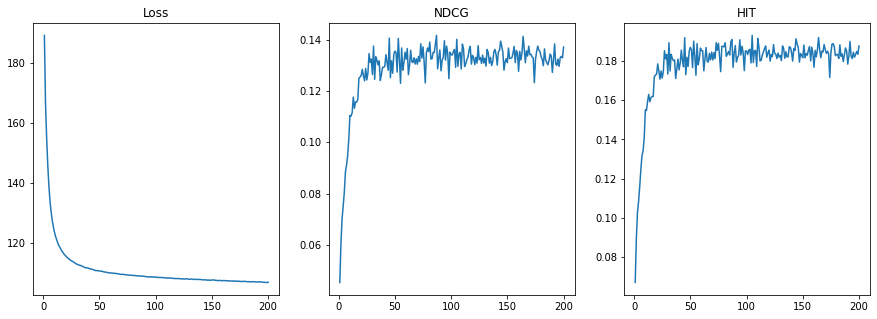

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 3, figsize = (15, 5))
ax = ax.flatten()
epochs = [i for i in range(1, config.num_epochs + 1)]

ax[0].plot(epochs, loss_list)
ax[0].set_title('Loss')

ax[1].plot(epochs, ndcg_list)
ax[1].set_title('NDCG')

ax[2].plot(epochs, hit_list)
ax[2].set_title('HIT')
plt.show()

In [ ]:
torch.save(model, 'RecVAE1.pt')

# 결과 확인

In [ ]:
def predict(model, data_loader, user_train, user_valid, make_matrix_data_set):
    model.eval()
    
    user2rec_list = {}
    with torch.no_grad():
        for users in data_loader:
            mat = make_matrix_data_set.make_matrix(users, train = False)
            mat = mat.to(device)

            recon_mat = model(mat, calculate_loss = False)
            recon_mat[mat == 1] = -np.inf
            rec_list = recon_mat.argsort(dim = 1)

            for user, rec in zip(users, rec_list):
                up = rec[-10:].cpu().numpy().tolist()[::-1]
                user2rec_list[user.item()] = up
    
    return user2rec_list

In [ ]:
model = torch.load('RecVAE1.pt')

submission_data_loader = DataLoader(
    ae_dataset,
    batch_size = config.batch_size, 
    shuffle = False, 
    pin_memory = True,
    num_workers = config.num_workers,
    )

user2rec_list = predict(
    model = model, 
    data_loader = data_loader,
    user_train = user_train, 
    user_valid = user_valid, 
    make_matrix_data_set = make_matrix_data_set
    )

submision = []
users = [i for i in range(0, make_matrix_data_set.num_user)]
for user in users:
    rec_item_list = user2rec_list[user]
    for item in rec_item_list:
        submision.append(
            {   
                'user' : make_matrix_data_set.user_decoder[user],
                'item' : make_matrix_data_set.item_decoder[item],
            }
        )

submision = pd.DataFrame(submision)

In [ ]:
submision['user'] = submision['user'] + 4532

In [ ]:
submision

,user,item
0,4532,2499.0
1,4532,205.0
2,4532,2235.0
3,4532,2514.0
4,4532,137.0
...,...,...
515,4583,1218.0
516,4583,1369.0
517,4583,29.0
518,4583,343.0


In [ ]:
submision.to_csv(os.path.join('model/', 'RecVAE.csv'), index=True)